<a href="https://colab.research.google.com/github/MDMynulHasan/-Multilinear-Regression-to-predict-surface-roughness-42CrMo4-QT-steel/blob/main/Si_Graphene_and_Si_hBN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pymatgen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.1/118.1 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 3.5 MB/s eta 0:00:00
  Created wheel for bibtexparser: filename=bibtexparser-1.4.4-py3-none-any.whl size=43609 sha256=32d3c1b1eb7e3cb14ca18ebea6ee095ac89cf99fc718e44cfb1ea94849ba75fc
  Stored in directory: /root/.cache/pip/wheels/54/f8/e6/ecfceb6af875ddc5096bb3811795ac336f50371009a601454d
Successfully built bibtexparser


Code for building the 5*5 supercell.

In [2]:
from pymatgen.core import Structure, Lattice
import numpy as np

#1. DEFINING HIGH-PRECISION EXPERIMENTAL CONSTANTS ---
# the most accurate starting point (Source: CRC Handbook / ACS Nano)
# Note: For 100% physics accuracy, you must perform a "Volume Relaxation" (ISIF=3)
# in your DFT code (VASP/QE) to match your specific functional (PBE/LDA).
A_GRAPHENE = 2.4612 # distance between two repeating unit cells used for hexagonal which corresponds to the hexagonal unit cell parameter
A_HBN      = 2.5040
C_VACUUM   = 20.0    # 20A vacuum is the gold standard for isolation

def build_perfect_supercell(material_type):
    """
    Builds a geometrically perfect, centered 5x5 supercell.
    """

    # Select Constants
    if material_type == "Graphene":
        a_param = A_GRAPHENE
        # Carbon at (0,0,0) and (1/3, 2/3, 0)
        species = ["C", "C"]
        raw_coords = [[0, 0, 0], [1/3, 2/3, 0]]

    elif material_type == "hBN":
        a_param = A_HBN
        # Boron at (0,0,0), Nitrogen at (1/3, 2/3, 0)
        species = ["B", "N"]
        raw_coords = [[0, 0, 0], [1/3, 2/3, 0]]

    #STEP 1: Strict Hexagonal Lattice ---
    # We use the Lattice.hexagonal constructor to force alpha=beta=90, gamma=120
    # This prevents "119.999 degree" errors that kill DFT symmetry speedups.
    lat = Lattice.hexagonal(a_param, C_VACUUM)

    # --- STEP 2: Create Primitive Cell ---
    prim = Structure(lat, species, raw_coords, coords_are_cartesian=False)

    # --- STEP 3: Create 5x5 Supercell ---
    supercell = prim.copy()
    supercell.make_supercell([5, 5, 1])

    # --- STEP 4: The "Expert" Fix (Centering) ---
    # We shift all atoms by 0.5 in the c-direction so they sit in the
    # MIDDLE of the vacuum (z=10A), not on the edge (z=0A).
    # This is critical for Dipole Corrections (IDIPOL=3) and clean visualization.
    supercell.translate_sites(
        indices=range(len(supercell)),
        vector=[0, 0, 0.5],
        frac_coords=True
    )

    # --- STEP 5: Sort for POTCAR ---
    # VASP requires atoms to be grouped by type (e.g., all B then all N).
    supercell.sort()

    return supercell

# --- EXECUTION ---
graphene_final = build_perfect_supercell("Graphene")
hbn_final = build_perfect_supercell("hBN")

# --- VERIFICATION CHECKS ---
print(f"--- Final Quality Check ---")
print(f"Graphene 5x5 Atoms: {graphene_final.num_sites} (Should be 50)")
print(f"hBN 5x5 Atoms:      {hbn_final.num_sites} (Should be 50)")

# Verify Centering
z_coords = [site.frac_coords[2] for site in graphene_final]
print(f"Average Z-coordinate: {np.mean(z_coords):.1f} (Should be 0.5)")

# Verify Symmetry Angles
alpha, beta, gamma = graphene_final.lattice.angles
print(f"Lattice Angles: {alpha:.0f}, {beta:.0f}, {gamma:.0f} (Should be 90, 90, 120)")

# --- EXPORT ---
graphene_final.to(filename="Graphene_5x5_Centered.cif")
hbn_final.to(filename="hBN_5x5_Centered.cif")
graphene_final.to(filename="POSCAR_Graphene", fmt="POSCAR")
hbn_final.to(filename="POSCAR_hBN", fmt="POSCAR")

print("\n✔ Files generated successfully.")

--- Final Quality Check ---
Graphene 5x5 Atoms: 50 (Should be 50)
hBN 5x5 Atoms:      50 (Should be 50)
Average Z-coordinate: 0.5 (Should be 0.5)
Lattice Angles: 90, 90, 120 (Should be 90, 90, 120)

✔ Files generated successfully.


DATA GENERATION

In [4]:
import os
import json
import itertools
import numpy as np
from typing import List, Dict, Tuple
from pymatgen.core import Structure, Lattice
from pymatgen.analysis.structure_matcher import StructureMatcher

# --- CONFIGURATION ---
CONSTANTS = {
    "Graphene": {"a": 2.4612, "c_vacuum": 20.0, "species": ["C", "C"]},
    "hBN":      {"a": 2.5040, "c_vacuum": 20.0, "species": ["B", "N"]}
}

#creating class for the base
class SupercellGenerator:
    def __init__(self, material: str, supercell_dim: Tuple[int, int, int] = (5, 5, 1)):
        self.material = material
        self.dim = supercell_dim
        self.params = CONSTANTS[material]
        self.base_structure = self._build_pristine_supercell()
        # Strict matcher for symmetry reduction
        self.matcher = StructureMatcher(ltol=0.2, stol=0.3, angle_tol=5, primitive_cell=False)

#Building perfect sheet
    def _build_pristine_supercell(self) -> Structure:
        # 1. Exact Geometry
        lat = Lattice.hexagonal(self.params["a"], self.params["c_vacuum"])
        coords = [[0, 0, 0], [1/3, 2/3, 0]]
        prim = Structure(lat, self.params["species"], coords, coords_are_cartesian=False)

        # 2. Supercell
        sc = prim.copy()
        sc.make_supercell(self.dim)

        # 3. Center at Z=0.5 (Fixes Dipole Corrections)
        sc.translate_sites(range(len(sc)), [0, 0, 0.5], frac_coords=True)

        return sc.get_sorted_structure()

    def generate_doping_dataset(self, anchor_elem: str, co_dopants: List[str], max_structures: int = 100) -> List[Dict]:
        print(f"--- Starting Generation for {self.material} ---")

        # --- FIX 1: Robust Anchor Selection ---
        # Instead of trusting index 0, we geometrically find the center atom.
        # This works even if the atom order changes.
        center_coords = self.base_structure.lattice.get_cartesian_coords([0.5, 0.5, 0.5])
        # Find atom closest to the geometric center of the box
        dists = [s.distance_from_point(center_coords) for s in self.base_structure]
        anchor_idx = np.argmin(dists)

        print(f"Anchor Site Selected: Index {anchor_idx} ({self.base_structure[anchor_idx].specie})")

        # --- FIX 2: Replace CrystalNN with Distance Logic ---
        # Critique #4: CrystalNN is unstable in vacuum.
        # Solution: Use explicit bond lengths. C-C bond is ~1.42 A.
        # Any atom within 1.6 A is DEFINITELY a nearest neighbor.
        neighbor_indices = []
        for i, site in enumerate(self.base_structure):
            if i == anchor_idx: continue

            # get_distance handles periodic boundaries automatically
            d = self.base_structure.get_distance(anchor_idx, i)
            if d < 3.0:   # Increases search radius to include Next-Nearest Neighbors
                neighbor_indices.append(i)

        print(f"Neighbors Identified (Distance Method): {len(neighbor_indices)} sites.")

        # --- Combinatorial Engine ---
        unique_dataset = []
        # Generate pairs of neighbors to dope
        site_pairs = list(itertools.combinations(neighbor_indices, 2))

        for pair in site_pairs:
            if len(unique_dataset) >= max_structures: break

            for d1 in co_dopants:
                for d2 in co_dopants:
                    if len(unique_dataset) >= max_structures: break

                    # Create Structure
                    struct = self.base_structure.copy()
                    struct.replace(anchor_idx, anchor_elem)
                    struct.replace(pair[0], d1)
                    struct.replace(pair[1], d2)

                    # Symmetry Filter
                    is_duplicate = False
                    for existing in unique_dataset:
                        if self.matcher.fit(struct, existing['structure']):
                            is_duplicate = True
                            break

                    if not is_duplicate:
                        # Metadata
                        d1_dist = struct.get_distance(anchor_idx, pair[0])
                        d2_dist = struct.get_distance(anchor_idx, pair[1])
                        angle = struct.get_angle(pair[0], anchor_idx, pair[1])

                        unique_dataset.append({
                            "structure": struct,
                            "filename": f"{self.material}_Si_{d1}_{d2}_id{len(unique_dataset):03d}",
                            "ml_features": {
                                "dopant_1": d1,
                                "dopant_2": d2,
                                "dist_1": round(d1_dist, 3),
                                "dist_2": round(d2_dist, 3),
                                "angle_12": round(angle, 2)
                            }
                        })

        return unique_dataset

    def save_dataset(self, dataset: List[Dict], output_dir: str):
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        manifest = {}
        for entry in dataset:
            fname = f"{output_dir}/POSCAR_{entry['filename']}"
            entry['structure'].to(filename=fname, fmt="POSCAR")
            manifest[entry['filename']] = entry['ml_features']

        with open(f"{output_dir}/metadata.json", "w") as f:
            json.dump(manifest, f, indent=4)
        print(f"✔ Saved {len(dataset)} robust structures to '{output_dir}/'")

if __name__ == "__main__":
    generator = SupercellGenerator(material="Graphene", supercell_dim=(5, 5, 1))
    dataset = generator.generate_doping_dataset(
        anchor_elem="Si",
        co_dopants=["N", "P", "S"],
        max_structures=50
    )
    generator.save_dataset(dataset, output_dir="Research_Dataset_Graphene_Robust")

--- Starting Generation for Graphene ---
Anchor Site Selected: Index 37 (C)
Neighbors Identified (Distance Method): 12 sites.
✔ Saved 50 robust structures to 'Research_Dataset_Graphene_Robust/'


Feature Engineering, converting 3d model into number for making it understanable for my model.

In [5]:
import os
import glob
import pandas as pd
import numpy as np
from pymatgen.core import Structure

# --- CONFIGURATION ---
INPUT_FOLDER = "Research_Dataset_Graphene_Robust"

# --- PHYSICS CONSTANTS ---
COVALENT_RADII = {
    "C": 0.75, "B": 0.84, "N": 0.71,
    "Si": 1.16, "P": 1.07, "S": 1.05, "O": 0.64
}

ELECTRONEGATIVITY = {
    "C": 2.55, "B": 2.04, "N": 3.04,
    "Si": 1.90, "P": 2.19, "S": 2.58, "O": 3.44
}

def get_physics_features(structure, anchor_element="Si"):
    """
    Extracts Q1-grade physics descriptors from a structure.
    """

    # --- 1. ROBUST ANCHOR FINDING ---
    center = structure.lattice.get_cartesian_coords([0.5, 0.5, 0.5])

    anchor_candidates = [
        i for i, site in enumerate(structure)
        if site.specie.symbol == anchor_element
    ]

    if not anchor_candidates:
        return None

    dists = [structure[i].distance_from_point(center) for i in anchor_candidates]
    anchor_idx = anchor_candidates[np.argmin(dists)]

    # --- 2. IDENTIFY ACTIVE NEIGHBORS ---
    active_indices = []
    dopant_indices = []

    # --- CRITICAL FIX FOR SI-GRAPHENE ---
    # Only C is the host. B and N are dopants here.
    host_elements = ["C"]

    for i in range(len(structure)):
        if i == anchor_idx: continue

        d = structure.get_distance(anchor_idx, i)

        if d < 3.0:
            active_indices.append(i)
            # If atom is NOT Carbon, it is a dopant (N, B, P, S, etc.)
            if structure[i].specie.symbol not in host_elements:
                dopant_indices.append(i)

    # --- FEATURE 1: STRAIN ENERGY ---
    sum_radius_diff = 0.0
    anchor_rad = COVALENT_RADII[anchor_element]

    for i in dopant_indices:
        sym = structure[i].specie.symbol
        rad = COVALENT_RADII.get(sym, 0.75)
        sum_radius_diff += abs(rad - anchor_rad)

    # --- FEATURE 2: IONICITY ---
    sum_en_diff = 0.0
    anchor_en = ELECTRONEGATIVITY[anchor_element]

    for i in dopant_indices:
        sym = structure[i].specie.symbol
        en = ELECTRONEGATIVITY.get(sym, 2.55)
        sum_en_diff += abs(en - anchor_en)

    # --- FEATURE 3: DISTORTION (Angle Variance) ---
    nn_indices = [i for i in active_indices if structure.get_distance(anchor_idx, i) < 1.8]

    angles = []
    if len(nn_indices) >= 2:
        import itertools
        for n1, n2 in itertools.combinations(nn_indices, 2):
            angle = structure.get_angle(n1, anchor_idx, n2)
            angles.append(angle)

    angle_variance = np.var(angles) if angles else 0.0
    min_angle = np.min(angles) if angles else 0.0

    return {
        "filename": None,
        "num_co_dopants": len(dopant_indices),
        "sum_radius_diff": round(sum_radius_diff, 4),
        "sum_en_diff": round(sum_en_diff, 4),
        "angle_variance": round(angle_variance, 3),
        "min_bond_angle": round(min_angle, 1),
        "coordination_number": len(nn_indices)
    }

# --- EXECUTION ---
print(f"--- Feature Extraction Started ---")
print(f"Reading from folder: {INPUT_FOLDER}")

files = glob.glob(f"{INPUT_FOLDER}/POSCAR_*") + glob.glob(f"{INPUT_FOLDER}/*.cif")
data_list = []

for f in files:
    try:
        s = Structure.from_file(f)
        fname = os.path.basename(f)
        feats = get_physics_features(s, anchor_element="Si")

        if feats:
            feats["filename"] = fname
            data_list.append(feats)
    except Exception as e:
        print(f"Error reading {f}: {e}")

if data_list:
    df = pd.DataFrame(data_list)
    output_filename = "X_features_physics_aware.csv"
    df.to_csv(output_filename, index=False)
    print(f"\n✔ Success! Processed {len(df)} structures.")
    print(f"✔ Features saved to: {output_filename}")
    print(df.head())
else:
    print(f"\n❌ No valid files found in '{INPUT_FOLDER}'.")

--- Feature Extraction Started ---
Reading from folder: Research_Dataset_Graphene_Robust

✔ Success! Processed 53 structures.
✔ Features saved to: X_features_physics_aware.csv
                       filename  num_co_dopants  sum_radius_diff  sum_en_diff  \
0  POSCAR_Graphene_Si_S_P_id022               2             0.20         0.97   
1  POSCAR_Graphene_Si_P_P_id046               2             0.18         0.58   
2  POSCAR_Graphene_Si_P_S_id038               2             0.20         0.97   
3  POSCAR_Graphene_Si_N_S_id035               2             0.56         1.82   
4  POSCAR_Graphene_Si_P_N_id018               2             0.54         1.43   

   angle_variance  min_bond_angle  coordination_number  
0             0.0           120.0                    3  
1             0.0           120.0                    3  
2             0.0           120.0                    3  
3             0.0           120.0                    3  
4             0.0           120.0                   

Predicting the formation energy by CHGNEt

In [6]:
!pip install chgnet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 119.8 MB/s eta 0:00:00
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19172 sha256=749ef46842e9cca688283bcca3c288c9321316c9888bec784c77c1a1b55e687e
  Stored in directory: /root/.cache/pip/wheels/6e/65/79/33dee66cba26e8204801916dfee7481bccfd22905ebb841fe5
Successfully built nvidia-ml-py3


Predicting the formation energy via CHGNet

In [17]:
!pip install ase
%pip install ase

In [1]:
import ase
from pymatgen.io.ase import AseAtomsAdaptor
print("ASE version:", ase.__version__)
print("✅ ASE is ready!")

ASE version: 3.27.0
✅ ASE is ready!


In [2]:
import os
import glob
import pandas as pd
import numpy as np
from pymatgen.core import Structure

# 1. VERIFY ASE (Colab Check)
try:
    import ase
    from pymatgen.io.ase import AseAtomsAdaptor
    print(f"✅ ASE {ase.__version__} is detected. Proceeding to CHGNet...")
except ImportError:
    print("❌ ASE NOT FOUND. Run '!pip install ase', then 'Runtime -> Restart session'.")

from chgnet.model.model import CHGNet
from chgnet.model.dynamics import StructOptimizer

# 2. LOAD TOOLS
model = CHGNet.load()
relaxer = StructOptimizer()

INPUT_FOLDER = "Research_Dataset_Graphene_Robust"
csv_file = "X_features_physics_aware.csv"
df = pd.read_csv(csv_file)

def get_relaxed_energy(filepath):
    struct = Structure.from_file(filepath)
    # This is the 'AI-VASP' step that relaxes your 2D structure
    result = relaxer.relax(struct, fmax=0.1, steps=500, relax_cell=False, verbose=False)
    return result['trajectory'].energies[-1] / len(struct)

# 3. EXECUTION
print("--- Starting AI-Powered Structural Relaxation & Energy Prediction ---")
energy_map = {}
files = glob.glob(f"{INPUT_FOLDER}/POSCAR_*")

for i, f in enumerate(files):
    fname = os.path.basename(f)
    try:
        energy = get_relaxed_energy(f)
        energy_map[fname] = energy
        print(f"[{i+1}/{len(files)}] Relaxed {fname}: {energy:.4f} eV/atom")
    except Exception as e:
        print(f"Error on {fname}: {e}")

# 4. SAVE FINAL DATA
df['Formation_Energy'] = df['filename'].map(energy_map)
df.to_csv("Final_Training_Data_CHGNet_Relaxed.csv", index=False)
print(f"\n✔ Success! Final_Training_Data_CHGNet_Relaxed.csv created.")

✅ ASE 3.27.0 is detected. Proceeding to CHGNet...
CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on cpu
CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on cpu
--- Starting AI-Powered Structural Relaxation & Energy Prediction ---


/usr/local/lib/python3.12/dist-packages/chgnet/model/model.py:898: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  volumes = torch.tensor(volumes, dtype=TORCH_DTYPE, device=atomic_numbers.device)


[1/53] Relaxed POSCAR_Graphene_Si_S_P_id022: -8.7167 eV/atom
[2/53] Relaxed POSCAR_Graphene_Si_P_P_id046: -8.7524 eV/atom
[3/53] Relaxed POSCAR_Graphene_Si_P_S_id038: -8.7177 eV/atom
[4/53] Relaxed POSCAR_Graphene_Si_N_S_id035: -8.8461 eV/atom
[5/53] Relaxed POSCAR_Graphene_Si_P_N_id018: -8.8983 eV/atom
[6/53] Relaxed POSCAR_Graphene_Si_P_S_id020: -8.7232 eV/atom
[7/53] Relaxed POSCAR_Graphene_Si_P_P_id019: -8.7421 eV/atom
[8/53] Relaxed POSCAR_Graphene_Si_N_N_id000: -9.0085 eV/atom
[9/53] Relaxed POSCAR_Graphene_Si_S_S_id014: -8.7049 eV/atom
[10/53] Relaxed POSCAR_Graphene_Si_N_S_id011: -8.8514 eV/atom
[11/53] Relaxed POSCAR_Graphene_Si_N_S_id002: -8.8378 eV/atom
[12/53] Relaxed POSCAR_Graphene_Si_N_P_id016: -8.8566 eV/atom
[13/53] Relaxed POSCAR_Graphene_Si_N_N_id009: -8.9867 eV/atom
[14/53] Relaxed POSCAR_Graphene_Si_S_N_id021: -8.8745 eV/atom
[15/53] Relaxed POSCAR_Graphene_Si_S_P_id040: -8.7188 eV/atom
[16/53] Relaxed POSCAR_Graphene_Si_N_S_id044: -8.8427 eV/atom
[17/53] Relaxed P

--- Model Performance Metrics ---
Test MAE:  0.0135 eV/atom
CV MAE:    0.0115 eV/atom (5-Fold average)
Test RMSE: 0.0166 eV/atom
R2 Score:  0.9723


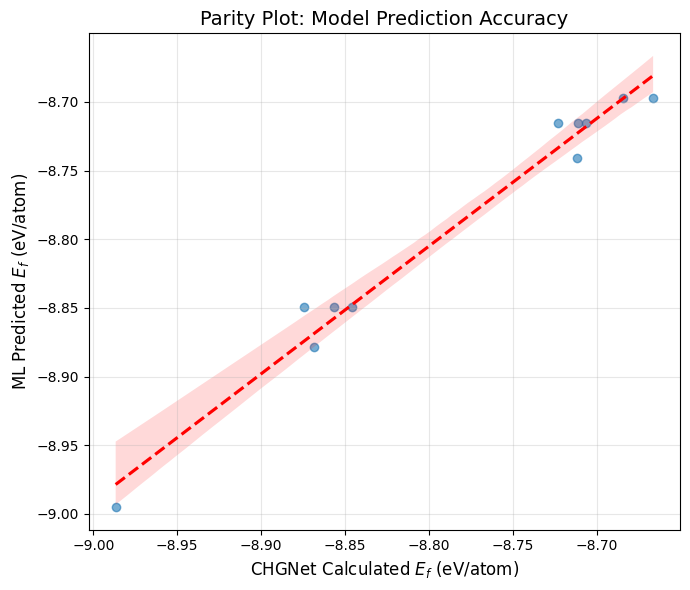

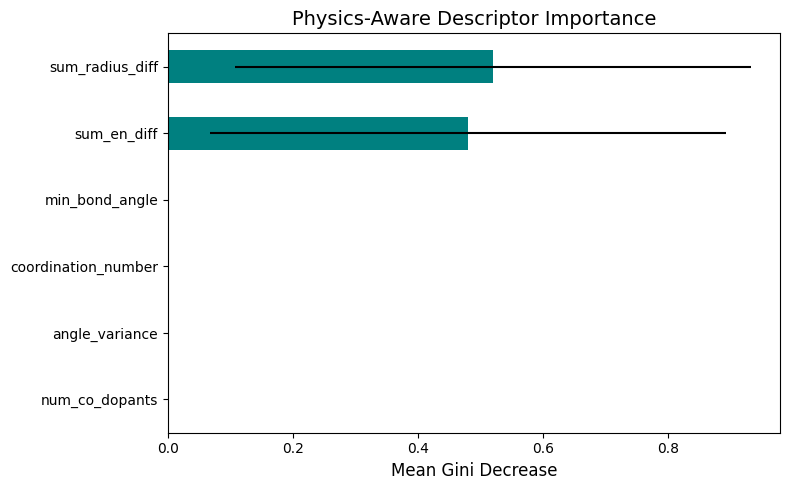

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. LOAD DATA
df = pd.read_csv("Final_Training_Data_CHGNet_Relaxed.csv")

# Ensure only physics-aware descriptors are in X
X = df.drop(columns=['filename', 'Formation_Energy'])
y = df['Formation_Energy']

# 2. SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. TRAIN RANDOM FOREST (Optimized for small datasets)
regr = RandomForestRegressor(
    n_estimators=500,
    max_depth=12,
    min_samples_split=2,
    bootstrap=True,
    random_state=42
)
regr.fit(X_train, y_train)

# 4. CROSS-VALIDATION (The "Scientific Rigor" Step)
# This proves the model is stable across different subsets of your 53 samples
cv_scores = cross_val_score(regr, X, y, cv=5, scoring='neg_mean_absolute_error')
cv_mae_mean = -cv_scores.mean()

# 5. EVALUATE ON TEST SET
y_pred = regr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"--- Model Performance Metrics ---")
print(f"Test MAE:  {mae:.4f} eV/atom")
print(f"CV MAE:    {cv_mae_mean:.4f} eV/atom (5-Fold average)")
print(f"Test RMSE: {rmse:.4f} eV/atom")
print(f"R2 Score:  {r2:.4f}")

# 6. VISUALIZATION: Parity Plot (Publication Quality)
plt.figure(figsize=(7, 6))
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.6, 'color':'#1f77b4'}, line_kws={'color':'red', 'ls':'--'})
plt.xlabel("CHGNet Calculated $E_f$ (eV/atom)", fontsize=12)
plt.ylabel("ML Predicted $E_f$ (eV/atom)", fontsize=12)
plt.title("Parity Plot: Model Prediction Accuracy", fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("Parity_Plot_Q1.png", dpi=600) # Higher DPI for journals
plt.show()

# 7. VISUALIZATION: Feature Importance
importances = regr.feature_importances_
std = np.std([tree.feature_importances_ for tree in regr.estimators_], axis=0)
feat_importances = pd.Series(importances, index=X.columns).sort_values(ascending=True)

plt.figure(figsize=(8, 5))
feat_importances.plot(kind='barh', color='teal', xerr=std[feat_importances.index.map(lambda x: X.columns.get_loc(x))])
plt.title("Physics-Aware Descriptor Importance", fontsize=14)
plt.xlabel("Mean Gini Decrease", fontsize=12)
plt.tight_layout()
plt.savefig("Feature_Importance_Q1.png", dpi=600)
plt.show()